# 최적화
- 현재 모델은 투입용량을 예측  
- 하지만, 투입용량만으로는 자동화 시스템을 구성하는 데 부족함  
- 투입해야할 투입용량이 있을 때, 어떤 일반 리액터가 투입되어야 하고 가변형 리액터의 탭 파라미터는 어디에 있어야 하는지를 최종적인 결과로 도출할 수 있어야 함  
- 또한, 각 전력설비 투입 시 추가적인 비용을 고려해야 함  
- 즉, 만약 180만큼의 투입용량이 필요하다면 일반 리액터 하나를 투입할지(투입용량 200), 아니면 가변형 리액터를 투입하고 탭 파라미터를 16으로 설정할지(투입용량 = 183)를 결정할 수 있는 기준이 필요함  
- 기준 : 각 전력설비의 사용 횟수  
- '전력설비는 다빈도로 동작시 고장을 야기할 수 있음'  
- 따라서, 예측한 만큼의 투입용량을 투입하되, 각 전력설비의 사용빈도를 고려하여 적절히 배분한다.  
 -> 최적화 문제

In [1]:
# 주피터 노트북 전체화면 설정
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# 필요한 라이브러리 불러오기
import numpy as np

## 1. 공식 및 구현
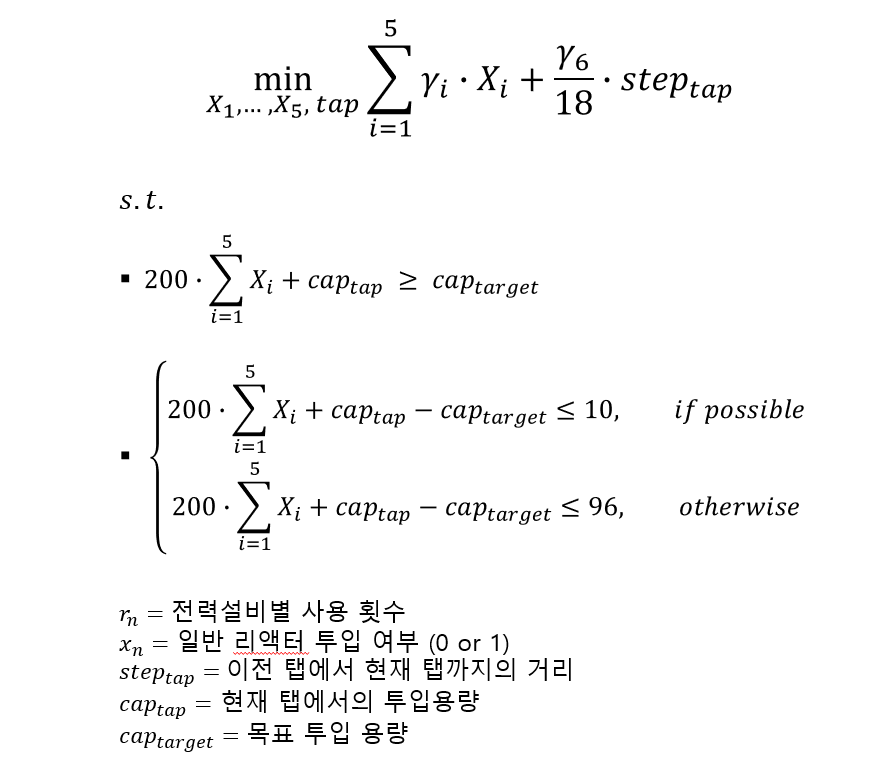

In [2]:
def optimize(cap_pred, params_now, n_used) :
    
    # 가변형 리액터 탭별 투입용량
    tap_cap = [0, 97, 101, 105, 109, 114, 119, 124, 129, 135, 140, 147, 153, 160, 167, 175, 183, 192, 200]
    
    # 결과 저장 테이블
    table = np.zeros((608, 8))
    
    # 현재 전력설비 상태 저장
    x1_now, x2_now, x3_now, x4_now, x5_now, tap_now = params_now
    
    # Cost 및 투입용량 계산 후 저장
    cnt = 0
    for x1 in range(2) :
        for x2 in range(2) :
            for x3 in range(2) :
                for x4 in range(2) :
                    for x5 in range(2) :
                        for tap in range(0, 19) :
                            # 투입용량
                            cap = 200 * (x1 + x2 + x3 + x4 + x5) + tap_cap[tap]

                            # Cost
                            cost = (n_used[0] * np.abs(x1 - x1_now) + n_used[1] * np.abs(x2 - x2_now)
                            + n_used[2] * np.abs(x3 - x3_now) + n_used[3] * np.abs(x4 - x4_now)
                            + n_used[4] * np.abs(x5 - x5_now) + (n_used[5] / 18) * np.abs(tap - tap_now))

                            # 계산 결과 저장
                            table[cnt] = [x1, x2, x3, x4, x5, tap, cap, cost]

                            cnt += 1
    
    # 제약식 1
    cons1_ind = np.where(table[:,6] >= cap_pred)
    table = table[cons1_ind]
    
    # 제약식 2
    cons2_ind = np.where(table[:,6] - cap_pred <= 10)
    
    if len(cons2_ind[0]) == 0 :
        
        cons2_ind = np.where(table[:,6] - cap_pred <= 96)
        
        table = table[cons2_ind]
        
    else : 
        
        table = table[cons2_ind]
        
    # 최종 결과
    optimized_ind = np.argmin(table[:,-1])
    
    # 결과 저장
    x1_target, x2_target, x3_target, x4_target, x5_target, tap_target = table[optimized_ind,:6]
    
    return x1_target, x2_target, x3_target, x4_target, x5_target, tap_target, table[optimized_ind,6]

## 2. 적용 예시

In [3]:
# 예시1
cap_now = 400 # 현재 투입 용량
cap_pred = 827 # 예측한 필요 투입 용량
params = [1,0,1,0,0,0] # 현재 전력설비 상태
used_counts = [151, 100, 151, 151, 151, 51] # 현재 각 전력설비별 사용 빈도

# 결과
optimize(cap_pred, params, used_counts)

(1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 897.0)

In [4]:
## 예시2
cap_now = 567 # 현재 투입 용량
cap_pred = 300 # 예측한 필요 투입 용량
params = [1,1,0,0,0,14] # 현재 전력설비 상태
used_counts = [151, 100, 151, 151, 151, 51] # 현재 각 전력설비별 사용 빈도

# 결과
optimize(cap_pred, params, used_counts)

(1.0, 0.0, 0.0, 0.0, 0.0, 4.0, 309.0)